In [1]:
%matplotlib inline

In [2]:
import os
import time
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,LSTM, SimpleRNN, GRU, Bidirectional, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras import regularizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Stock Market Predictor Hybrid Models

# Preprocessing Data

## 1. Read and visualisation data

In [3]:
START_DATE = "2013-01-02"
END_DATE = "2021-12-31"
SPLIT_FACTOR = 0.85
# SPLIT_VAL_FACTOR = 0.25

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
stocks_data = pd.read_csv(r'data\stocks_df.csv', header=0, sep = ",", parse_dates=[0], date_parser=parser)
mask = (stocks_data['Date'] >= START_DATE) & (stocks_data['Date'] <= END_DATE)
stocks_df = stocks_data.loc[mask]
stocks_df.reset_index(inplace = True, drop = True)
stocks_df

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2013-01-02,1462.420044,13412.54980,3112.260010,8632.009766,14.680000,2269.127930,1.319784,86.599998,1.624695,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,2013-01-03,1459.369995,13391.36035,3100.570068,8607.790039,14.560000,2269.127930,1.318218,87.275002,1.625250,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,2013-01-04,1466.469971,13435.20996,3101.659912,8667.679688,13.830000,2276.991943,1.303271,87.739998,1.608234,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,2013-01-07,1461.890015,13384.29004,3098.810059,8636.910156,13.790000,2285.364014,1.306745,88.197998,1.606787,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,2013-01-08,1457.150024,13328.84961,3091.810059,8604.379883,13.620000,2276.070068,1.312508,87.252998,1.612201,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,4791.189941,36302.37891,15871.259770,17141.089840,17.680000,3615.969971,1.132426,114.333000,1.340430,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,2021-12-28,4786.350098,36398.21094,15781.719730,17134.160160,17.540001,3630.112061,1.133003,114.792000,1.344267,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,2021-12-29,4793.060059,36488.62891,15766.219730,17149.929690,16.950001,3597.000000,1.131478,114.773003,1.343328,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,2021-12-30,4778.729980,36398.07813,15741.559570,17164.240230,17.330000,3619.189941,1.136015,114.947998,1.349879,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


In [6]:
company_data = pd.read_csv(r'data\company_dataset_ts.csv', header=0, sep = ",", parse_dates=[0], date_parser=parser)
mask = (company_data['Date'] >= START_DATE) & (company_data['Date'] <= END_DATE)
company_df = company_data.loc[mask]
company_df.reset_index(inplace = True, drop = True)
company_df

,Date,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,2013-01-02,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,21.725426,...,28.139999,28.670000,6677100.0,21.331152,21.544037,21.318136,67.940932,0.248235,28.276532,26.462801
1,2013-01-03,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,...,28.760000,28.440001,3970700.0,21.405943,21.617482,21.379340,64.147275,0.281482,28.441684,26.473316
2,2013-01-04,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,...,28.500000,29.219999,5842400.0,21.529171,21.782178,21.472446,70.220399,0.352791,28.711065,26.420268
3,2013-01-07,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,...,29.100000,28.010000,8339200.0,21.555511,21.842271,21.520297,54.732007,0.329450,28.761600,26.540400
4,2013-01-08,22.075964,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,...,27.930000,28.340000,3880400.0,21.602825,21.936860,21.580389,57.486147,0.327915,28.805516,26.614484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,64.849998,...,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,58.105626,0.302337,66.388560,62.033441
2263,2021-12-28,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,...,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,61.772180,0.438992,66.711888,61.891113
2264,2021-12-29,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,...,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,62.104439,0.547438,67.116617,61.917051
2265,2021-12-30,66.860001,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,...,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,61.033303,0.614197,67.396706,62.084962


In [7]:
stocks_df[stocks_df.isna().any(axis=1)]

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE


In [8]:
company_df[company_df.isna().any(axis=1)]

,Date,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold


In [9]:
stocks_df.shape, company_df.shape

((2267, 87), (2267, 44))

In [10]:
stocks_df.describe().T

,count,mean,std,min,25%,50%,75%,max
^GSPC,2267.0,2592.580396,781.401906,1457.150024,2020.714966,2432.459961,2935.729981,4793.060059
^DJI,2267.0,22382.318566,5996.247598,13328.849610,17323.235355,21328.470700,26327.334960,36488.628910
^IXIC,2267.0,7115.422644,3284.071455,3091.810059,4727.080079,6234.410156,8118.175049,16057.440430
^NYA,2267.0,11933.662107,1996.464400,8604.379883,10515.500000,11514.400390,12884.955075,17310.509770
^VIX,2267.0,17.000362,7.122941,9.140000,12.840000,14.910000,18.884999,82.690002
...,...,...,...,...,...,...,...,...
LIN,2267.0,152.325847,64.350183,85.154175,105.852566,121.700264,184.508926,346.429993
TXN,2267.0,85.135160,48.235800,25.013260,43.962057,72.645607,111.169167,201.289993
NEE,2267.0,38.130828,21.319112,13.006111,20.255817,31.979395,53.418072,93.360001
T10YIE,2267.0,2.171544,0.453418,0.040000,2.020000,2.320000,2.440000,2.760000


In [11]:
company_df.iloc[:, 32:].describe().T

,count,mean,std,min,25%,50%,75%,max
High,2267.0,4.503447e+01,7.657740e+00,28.360001,4.085000e+01,4.383000e+01,4.827500e+01,6.930000e+01
Low,2267.0,4.422260e+01,7.582431e+00,27.900000,4.016000e+01,4.317000e+01,4.741500e+01,6.846000e+01
Open,2267.0,4.462786e+01,7.629530e+00,27.930000,4.049500e+01,4.350000e+01,4.789500e+01,6.890000e+01
Close,2267.0,4.463629e+01,7.616271e+00,28.010000,4.051000e+01,4.351000e+01,4.790000e+01,6.877000e+01
Volume,2267.0,3.441749e+06,1.527734e+06,411600.000000,2.394800e+06,3.059500e+06,4.073400e+06,1.580600e+07
ewm,2267.0,3.931158e+01,8.790396e+00,21.331152,3.545468e+01,3.804518e+01,4.145121e+01,6.617754e+01
ma_7,2267.0,3.944639e+01,8.920868e+00,21.544037,3.523192e+01,3.815702e+01,4.161527e+01,6.755831e+01
ma_21,2267.0,3.931136e+01,8.816601e+00,21.318136,3.536850e+01,3.814080e+01,4.142848e+01,6.649386e+01
rsi,2267.0,5.329094e+01,1.193041e+01,17.612588,4.590389e+01,5.342373e+01,6.184395e+01,8.412706e+01
macd,2267.0,1.349350e-01,6.238122e-01,-2.827388,-1.411524e-01,1.662251e-01,5.097131e-01,2.376329e+00


In [12]:
corr = company_df.iloc[:, 32:].corr()
corr.style.background_gradient(cmap='coolwarm')

,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
High,1.000000,0.998552,0.998900,0.998817,-0.289261,0.945246,0.953304,0.941304,0.164937,0.302025,0.966090,0.970226
Low,0.998552,1.000000,0.998783,0.998879,-0.313850,0.940437,0.949398,0.936317,0.177053,0.313006,0.961181,0.970053
Open,0.998900,0.998783,1.000000,0.997514,-0.300973,0.943837,0.952307,0.939888,0.159626,0.306421,0.964821,0.971226
Close,0.998817,0.998879,0.997514,1.000000,-0.302737,0.941945,0.950543,0.937814,0.181961,0.308971,0.962174,0.968840
Volume,-0.289261,-0.313850,-0.300973,-0.302737,1.000000,-0.305286,-0.314495,-0.300841,-0.145541,-0.177068,-0.242470,-0.289600
ewm,0.945246,0.940437,0.943837,0.941945,-0.305286,1.000000,0.996247,0.999240,0.014685,0.174515,0.947337,0.935419
ma_7,0.953304,0.949398,0.952307,0.950543,-0.314495,0.996247,1.000000,0.993461,0.082388,0.255090,0.939418,0.931786
ma_21,0.941304,0.936317,0.939888,0.937814,-0.300841,0.999240,0.993461,1.000000,-0.004981,0.159061,0.949391,0.937454
rsi,0.164937,0.177053,0.159626,0.181961,-0.145541,0.014685,0.082388,-0.004981,1.000000,0.797336,-0.028424,0.008555
macd,0.302025,0.313006,0.306421,0.308971,-0.177068,0.174515,0.255090,0.159061,0.797336,1.000000,0.128380,0.183394


In [13]:
corr = stocks_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [12]:
num_training_days = int(company_df.shape[0]*SPLIT_FACTOR)
split_point = company_df[num_training_days: num_training_days+1].values[0][0]
year = split_point.year
month = split_point.month
day = split_point.day
print(f"Number of training days: {num_training_days}. Number of test days: {company_df.shape[0]-num_training_days}.")
print(f"Split date is: {split_point}. Index is: {company_df[num_training_days: num_training_days+1].index.values[0]}")

Number of training days: 1926. Number of test days: 341.
Split date is: 2020-08-26 00:00:00. Index is: 1926


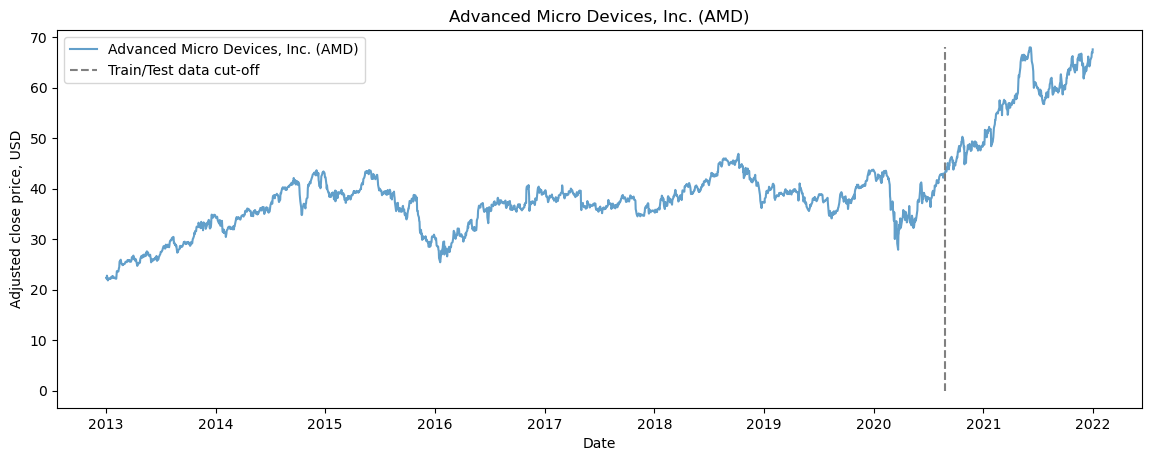

In [13]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(company_df['Date'], company_df['Adj Close'], label='Advanced Micro Devices, Inc. (AMD)', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.show()

In [14]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(3, 1, 1)
    plt.plot(dataset['ma_7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['ma_21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['Adj Close'],label='Adj Close', color='b')
    plt.plot(dataset['bolu'],label='Bollinger Upper Band', color='c')
    plt.plot(dataset['bold'],label='Bollinger Lower Band', color='c')
    plt.fill_between(x_, dataset['bolu'], dataset['bold'], alpha=0.35)
    plt.title('Technical indicators for Advanced Micro Devices, Inc. (AMD) - last {} days.'.format(last_days))
    plt.ylabel('Adjusted close price, USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(3, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['macd'],label='MACD', linestyle='-.')
    plt.hlines(5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.legend()
    
    # Plot tirth subplot
    plt.subplot(3, 1, 3)
    plt.title('RSI')
    plt.plot(dataset['rsi'],label='RSI', color='b',linestyle='-')
    plt.legend()
    
    plt.show()

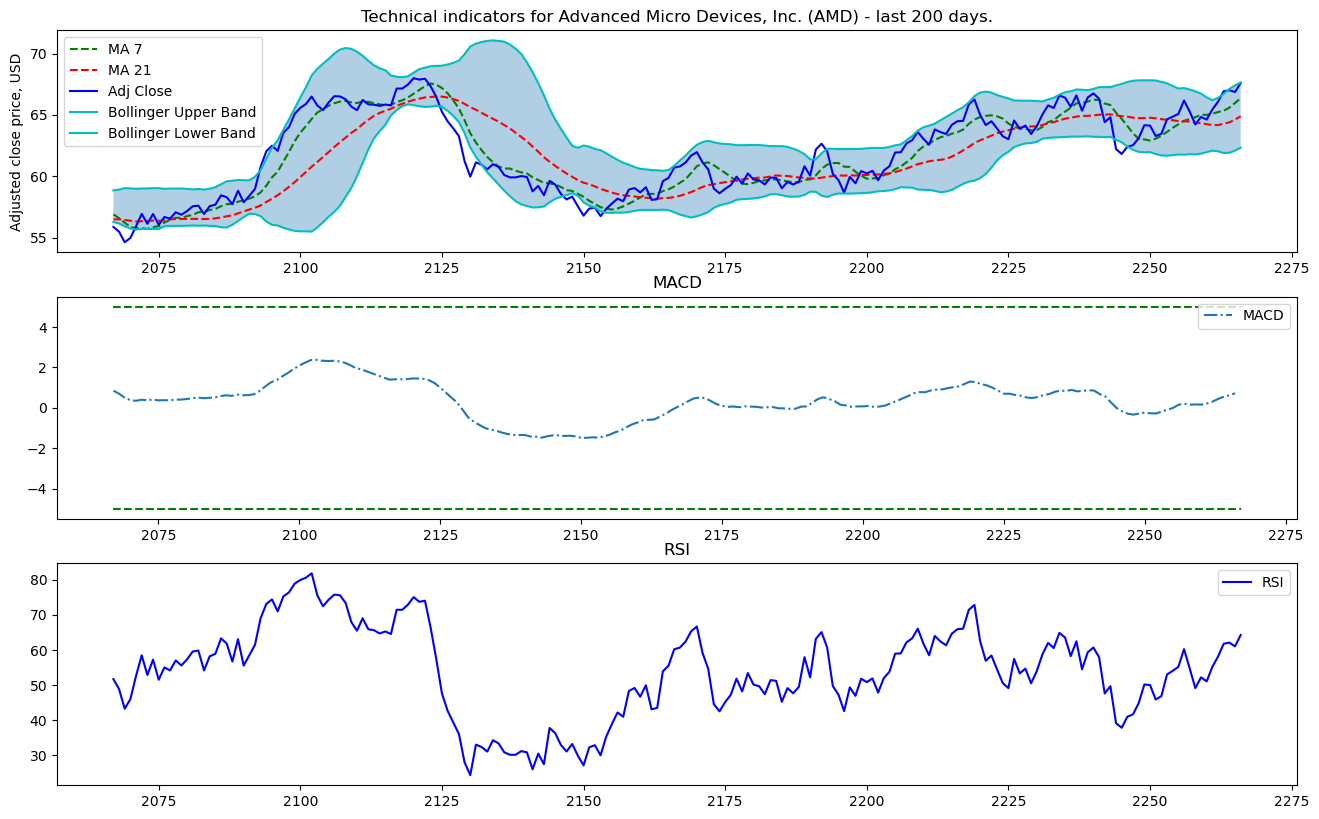

In [15]:
plot_technical_indicators(company_df, 200)

In [16]:
print('Total dataset for company has {} samples, and {} features.'.format(company_df.shape[0], company_df.shape[1]))
print('Total dataset for other market features has {} samples, and {} features.'.format(stocks_df.shape[0], stocks_df.shape[1]))

Total dataset for company has 2267 samples, and 44 features.
Total dataset for other market features has 2267 samples, and 87 features.


In [17]:
full_df = company_df.merge(stocks_df, left_index=True,right_index=True)
full_df.shape

(2267, 131)

In [18]:
full_df = full_df.drop(labels=["Date_x", "Date_y"], axis=1)
full_df

,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,21.725426,21.873428,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,21.725426,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,22.075964,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,64.849998,64.639999,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,64.849998,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,66.860001,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


## 2. Normalize Data

In [19]:
def min_max_normalize_inverse_transform(data, MIN, MAX):
    i_data = data * (MAX - MIN)+ MIN
    return i_data

In [20]:
def min_max_normalize(data):
    n_data = (data - data.min()) / (data.max() - data.min())
    return n_data

In [21]:
MIN = full_df["Adj Close"].min(axis=0)
MAX = full_df["Adj Close"].max(axis=0)
MIN, MAX

(21.818906784057617, 67.9862289428711)

In [22]:
full_df_scaled = min_max_normalize(full_df)
full_df_scaled

,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,0.011136,0.000000,0.000000,0.007141,0.006809,0.011292,0.011957,0.016108,0.013783,0.016939,...,0.001044,0.057023,0.000000,0.000000,0.005292,0.031689,0.003418,0.000000,0.588235,0.683398
1,0.007255,0.021373,0.005480,0.000000,0.007141,0.006809,0.011292,0.011957,0.016108,0.013783,...,0.003017,0.057853,0.001489,0.000894,0.004034,0.031689,0.001529,0.000023,0.580882,0.679537
2,0.020416,0.017533,0.026736,0.005480,0.000000,0.007141,0.006809,0.011292,0.011957,0.016108,...,0.000000,0.066579,0.002921,0.000992,0.003035,0.034103,0.001214,0.000826,0.584559,0.685328
3,0.000000,0.030557,0.022917,0.026736,0.005480,0.000000,0.007141,0.006809,0.011292,0.011957,...,0.004100,0.073227,0.003146,0.000992,0.000000,0.033309,0.001664,0.000069,0.580882,0.679537
4,0.005568,0.010353,0.035870,0.022917,0.026736,0.005480,0.000000,0.007141,0.006809,0.011292,...,0.004216,0.048397,0.001573,0.000325,0.000074,0.035819,0.000000,0.001790,0.613971,0.689189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,0.958494,0.945419,0.928237,0.932714,0.919709,0.942094,0.961280,0.938043,0.933140,0.928663,...,0.998745,0.357262,0.937858,0.984232,0.966838,0.988480,0.946391,0.974612,0.727941,0.764479
2263,0.977122,0.958924,0.945718,0.928237,0.932714,0.919709,0.942094,0.961280,0.938043,0.933140,...,0.996939,0.360094,0.930358,0.971165,0.968219,0.989896,0.942193,0.981581,0.694853,0.747104
2264,0.978855,0.977359,0.959149,0.945718,0.928237,0.932714,0.919709,0.942094,0.961280,0.938043,...,1.000000,0.347349,0.945616,0.982199,0.983548,0.996058,0.940548,0.982950,0.705882,0.754826
2265,0.975606,0.979074,0.977483,0.959149,0.945718,0.928237,0.932714,0.919709,0.942094,0.961280,...,0.993576,0.357262,0.937276,0.988424,0.978453,0.991962,0.932606,0.992657,0.720588,0.766409


In [23]:
#test inverse_transform
test_number = sum(min_max_normalize_inverse_transform(full_df_scaled["Adj Close"], MIN, MAX))- sum(full_df["Adj Close"])
test_number

0.0

In [26]:
# full_df_scaled.min(), full_df_scaled.max()

## 3. Split Data

In [24]:
num_train_samples = int((SPLIT_FACTOR) * len(full_df_scaled))
num_test_samples = len(full_df_scaled) - num_train_samples
num_train_samples, num_test_samples

(1926, 341)

In [25]:
full_df_train = full_df_scaled.iloc[0:num_train_samples, 0:]
full_df_test = full_df_scaled.iloc[num_train_samples:, 0:]
full_df_train.shape, full_df_test.shape

((1926, 129), (341, 129))

## 4. Shift Data

In [26]:
full_df_train = full_df_train.sample(frac=1, random_state=42)
full_df_train

,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
1075,0.370773,0.375432,0.385497,0.385682,0.388449,0.395645,0.400073,0.401364,0.403763,0.394169,...,0.234409,0.717988,0.192403,0.183665,0.198370,0.093104,0.262066,0.198730,0.838235,0.876448
1650,0.342869,0.349075,0.349477,0.346905,0.345125,0.348092,0.358182,0.376383,0.379944,0.376185,...,0.659273,0.586111,0.402653,0.372070,0.299251,0.419409,0.547590,0.459295,0.525735,0.590734
1861,0.300681,0.271852,0.270513,0.275227,0.264363,0.277072,0.242982,0.243794,0.237300,0.255563,...,0.542869,0.525273,0.470264,0.425820,0.393681,0.393299,0.494504,0.542277,0.816176,0.812741
941,0.301406,0.308821,0.322975,0.332249,0.329158,0.317155,0.317701,0.314973,0.319519,0.314063,...,0.167929,0.698746,0.192832,0.155171,0.152275,0.078823,0.203489,0.175385,0.955882,0.942085
331,0.297018,0.304983,0.312376,0.314083,0.312034,0.316813,0.319374,0.319032,0.306231,0.313400,...,0.056552,0.176952,0.062559,0.026388,0.047172,0.095700,0.071327,0.070914,0.871324,0.884170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.304503,0.309086,0.318450,0.315847,0.313430,0.317520,0.321796,0.339644,0.341875,0.338157,...,0.347621,0.590176,0.184041,0.179643,0.178231,0.145127,0.254071,0.233793,0.878676,0.905405
1294,0.334984,0.348759,0.360893,0.371552,0.366508,0.340445,0.331380,0.330058,0.334213,0.331569,...,0.384908,0.588307,0.271917,0.221376,0.263044,0.221806,0.394862,0.270993,0.841912,0.866795
860,0.325132,0.320495,0.323135,0.331444,0.328554,0.317897,0.310131,0.281051,0.270033,0.243663,...,0.182727,0.544555,0.186044,0.070225,0.187297,0.051642,0.158661,0.154593,0.948529,0.957529
1459,0.489237,0.499766,0.497488,0.493433,0.490344,0.518726,0.544020,0.550585,0.536683,0.524905,...,0.427238,0.456332,0.334021,0.247567,0.289487,0.252601,0.388597,0.333645,0.819853,0.833977


## 5. Reshape Data

In [27]:
company_df.shape, stocks_df.shape

((2267, 44), (2267, 87))

In [28]:
X_train_company = full_df_train.iloc[:, 1:company_df.shape[1]-1]
y_train_company = full_df_train.iloc[:, 0]
X_test_company = full_df_test.iloc[:, 1:company_df.shape[1]-1]
y_test_company = full_df_test.iloc[:, 0]

X_train_stocks = full_df_train.iloc[:, company_df.shape[1]-1:]
y_train_stocks = full_df_train.iloc[:, 0]
X_test_stocks = full_df_test.iloc[:, company_df.shape[1]-1:]
y_test_stocks = full_df_test.iloc[:, 0]

In [29]:
X_train_company.shape, y_train_company.shape, X_test_company.shape, y_test_company.shape

((1926, 42), (1926,), (341, 42), (341,))

In [30]:
X_train_company = X_train_company.to_numpy().reshape(X_train_company.shape[0], 1, X_train_company.shape[1])
y_train_company = y_train_company.to_numpy()
X_test_company = X_test_company.to_numpy().reshape(X_test_company.shape[0], 1, X_test_company.shape[1])
y_test_company = y_test_company.to_numpy()

In [31]:
X_train_stocks = X_train_stocks.to_numpy().reshape(X_train_stocks.shape[0], 1, X_train_stocks.shape[1])
y_train_stocks = y_train_stocks.to_numpy()
X_test_stocks = X_test_stocks.to_numpy().reshape(X_test_stocks.shape[0], 1, X_test_stocks.shape[1])
y_test_stocks = y_test_stocks.to_numpy()

In [32]:
X_train_company.shape, y_train_company.shape, X_test_company.shape, y_test_company.shape

((1926, 1, 42), (1926,), (341, 1, 42), (341,))

In [33]:
X_train_stocks.shape, y_train_stocks.shape, X_test_stocks.shape, y_test_stocks.shape

((1926, 1, 86), (1926,), (341, 1, 86), (341,))

# MODELING DATA

In [34]:
def plot_history_loss(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'], c="green")
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')   
        
    plt.grid(True)

In [35]:
def plot_mae(history):
    plt.figure()    
    plt.plot(history.history['mae'], c="red") 
    plt.plot(history.history['val_mae'], c="green")
    plt.legend(['train_mae', 'val_mae'], loc='upper left')
    plt.title('Model Metrics')
    plt.ylabel('MAE')
    plt.xlabel('Epoch') 
      
    plt.grid(True)

In [36]:
def compile_fit_model(X_train,y_train, checkpoint_name, model, optimizer, epochs, batch_size, validation_split):
    callbacks = [ModelCheckpoint(checkpoint_name, monitor="mae", mode="min", save_best_only=True)]
    model.compile(optimizer= optimizer, loss="mse", metrics=["mae"])
    history = model.fit(
                        X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        callbacks=callbacks,
                        )
    return model, history 
# monitor="val_mae", monitor="val_loss"

In [82]:
def evaluate_model(model, X_test, y_test):
    return (f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")

# Hybrid models - Architectures

## LSTM-GRU two branches input model

In [271]:
tf.keras.backend.clear_session()

In [272]:
company_inputs = Input(shape=(1, X_train_company.shape [2]))
x = LSTM(128, activation = "relu", return_sequences=True)(company_inputs)
x = LSTM(64, activation = "relu", return_sequences=True)(x)
x = LSTM(32, activation = "relu",return_sequences=True)(x)
x = LSTM(16, activation = "relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=True)(x)
x = LSTM(32, activation = "relu",return_sequences=True)(x)
x = LSTM(16, activation = "relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=False)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.10)(x)
company_outputs = Dense(42)(x)

stocks_inputs = Input(shape=(1, X_train_stocks.shape [2]))
x = GRU(128, activation = "relu", return_sequences=True)(stocks_inputs)
x = GRU(64, activation = "relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=False)(x)# error 64
x = Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
stocks_outputs = Dense(86)(x)

concatenated =  Concatenate()([company_outputs, stocks_outputs])

x = Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(concatenated)
x = Dropout(0.10)(x)
x = Dense(64)(x)
out = Dense(1, activation='linear')(x)

hybrid_model = Model(inputs=[company_inputs, stocks_inputs], outputs=out)

In [273]:
hybrid_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 42)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 86)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 1, 128)       87552       input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 1, 128)       82944       input_2[0][0]                    
_______________________________________________________________________________________

In [274]:
opt_adadelta = Adadelta(lr=0.1, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.001, beta_1=0.90, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.90, epsilon=1e-08, decay=0.0)
epochs = 150
batch_size = 128
validation_split = 0.225
# https://stats.stackexchange.com/questions/351409/difference-between-rho-and-decay-arguments-in-keras-rmsprop

In [275]:
hybrid_model, history_hybrid = compile_fit_model([X_train_company, X_train_stocks], y_train_company, \
                "company_predictor_hybrid_lstm_gru.keras", hybrid_model, opt_rms, epochs, batch_size, validation_split)

Epoch 1/150
12/12 [==============================] - 1s 123ms/step - loss: 0.7092 - mae: 0.1816 - val_loss: 0.6315 - val_mae: 0.2752
Epoch 2/150
12/12 [==============================] - 0s 26ms/step - loss: 0.5054 - mae: 0.1056 - val_loss: 0.4867 - val_mae: 0.2383
Epoch 3/150
12/12 [==============================] - 0s 26ms/step - loss: 0.3844 - mae: 0.0829 - val_loss: 0.3664 - val_mae: 0.2008
Epoch 4/150
12/12 [==============================] - 0s 25ms/step - loss: 0.2863 - mae: 0.0734 - val_loss: 0.2687 - val_mae: 0.1727
Epoch 5/150
12/12 [==============================] - 0s 25ms/step - loss: 0.2052 - mae: 0.0582 - val_loss: 0.1909 - val_mae: 0.1497
Epoch 6/150
12/12 [==============================] - 0s 26ms/step - loss: 0.1441 - mae: 0.0600 - val_loss: 0.1340 - val_mae: 0.1366
Epoch 7/150
12/12 [==============================] - 0s 22ms/step - loss: 0.0979 - mae: 0.0568 - val_loss: 0.0956 - val_mae: 0.1329
Epoch 8/150
12/12 [==============================] - 0s 24ms/step - loss: 0

12/12 [==============================] - 0s 19ms/step - loss: 0.0027 - mae: 0.0313 - val_loss: 0.0052 - val_mae: 0.0551
Epoch 63/150
12/12 [==============================] - 0s 19ms/step - loss: 0.0029 - mae: 0.0329 - val_loss: 0.0043 - val_mae: 0.0464
Epoch 64/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0030 - mae: 0.0338 - val_loss: 0.0033 - val_mae: 0.0372
Epoch 65/150
12/12 [==============================] - 0s 18ms/step - loss: 0.0029 - mae: 0.0336 - val_loss: 0.0068 - val_mae: 0.0661
Epoch 66/150
12/12 [==============================] - 0s 18ms/step - loss: 0.0033 - mae: 0.0362 - val_loss: 0.0040 - val_mae: 0.0457
Epoch 67/150
12/12 [==============================] - 0s 19ms/step - loss: 0.0029 - mae: 0.0326 - val_loss: 0.0047 - val_mae: 0.0494
Epoch 68/150
12/12 [==============================] - 0s 19ms/step - loss: 0.0030 - mae: 0.0347 - val_loss: 0.0046 - val_mae: 0.0467
Epoch 69/150
12/12 [==============================] - 0s 23ms/step - loss: 0.0027 

In [276]:
mae = round(hybrid_model.evaluate([X_test_company, X_test_stocks], y_test_company)[1], 2)
file_chart_name = f"Test MAE: {mae}"
print(f"Test MAE: {mae}")

11/11 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0495
Test MAE: 0.05


In [291]:
# layer_names = [hybrid_model.layers[i].name for i in range(0, 25)]
# layer_names

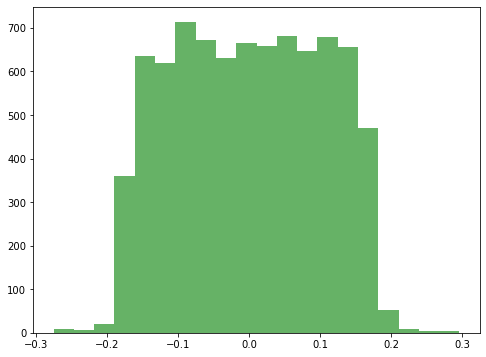

In [305]:
# plt.figure()
# #dense_1 output 42
# plt.hist(hybrid_model.layers[18].kernel.numpy().ravel(), bins = 50, facecolor='g', alpha=0.6)
# plt.figure()
# # dense_4 output 86
# plt.hist(hybrid_model.layers[19].kernel.numpy().ravel(), bins = 50, facecolor='g', alpha=0.6)

plt.figure()
#dense_6
plt.hist(hybrid_model.layers[23].kernel.numpy().ravel(), bins = 20, facecolor='g', alpha=0.6)
plt.show()

In [299]:
hist = pd.DataFrame(history_hybrid.history)
hist['epoch'] = history_hybrid.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
145,0.002359,0.030027,0.004055,0.050509,145
146,0.002848,0.034716,0.006669,0.069835,146
147,0.002283,0.029302,0.003394,0.040451,147
148,0.002494,0.030592,0.003433,0.040048,148
149,0.002243,0.028154,0.002667,0.036330,149


(None, None)

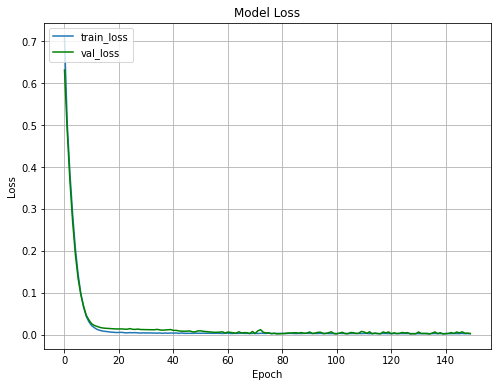

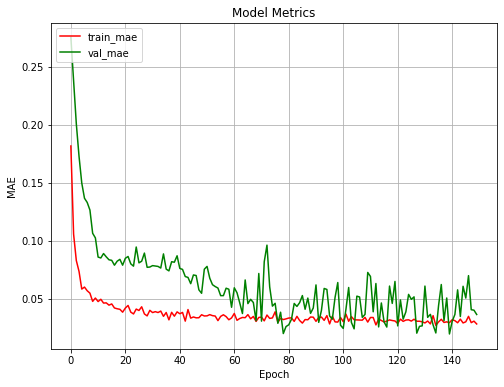

In [280]:
plot_history_loss(history_hybrid), plot_mae(history_hybrid)

In [306]:
predicted_stock_price = hybrid_model.predict([X_test_company, X_test_stocks])

In [307]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
before_df = pd.DataFrame(company_df.iloc[0:1926, 0:2])
before_df["Predicted Close"] = before_df["Adj Close"]
df_char = pd.concat([before_df, predicted_df])
df_char["Year"] = pd.DatetimeIndex(df_char['Date']).year
df_char

,Date,Adj Close,Predicted Close,Year
0,2013-01-02,22.333015,22.333015,2013
1,2013-01-03,22.153860,22.153860,2013
2,2013-01-04,22.761452,22.761452,2013
3,2013-01-07,21.818907,21.818907,2013
4,2013-01-08,22.075964,22.075964,2013
...,...,...,...,...
2262,2021-12-27,66.070000,66.052673,2021
2263,2021-12-28,66.930000,65.735275,2021
2264,2021-12-29,67.010002,65.906166,2021
2265,2021-12-30,66.860001,65.798470,2021


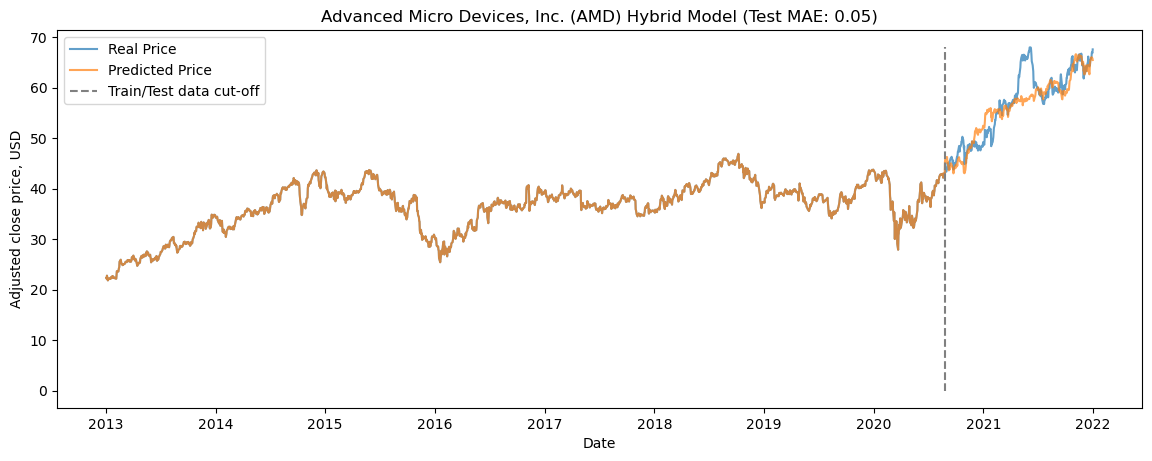

In [308]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title(f'Advanced Micro Devices, Inc. (AMD) Hybrid Model ({file_chart_name})')
plt.legend()
# plt.savefig(f"pictures/hybrid_model_gru_test_MAE_{file_chart_name[-4:]}.png")
plt.show()

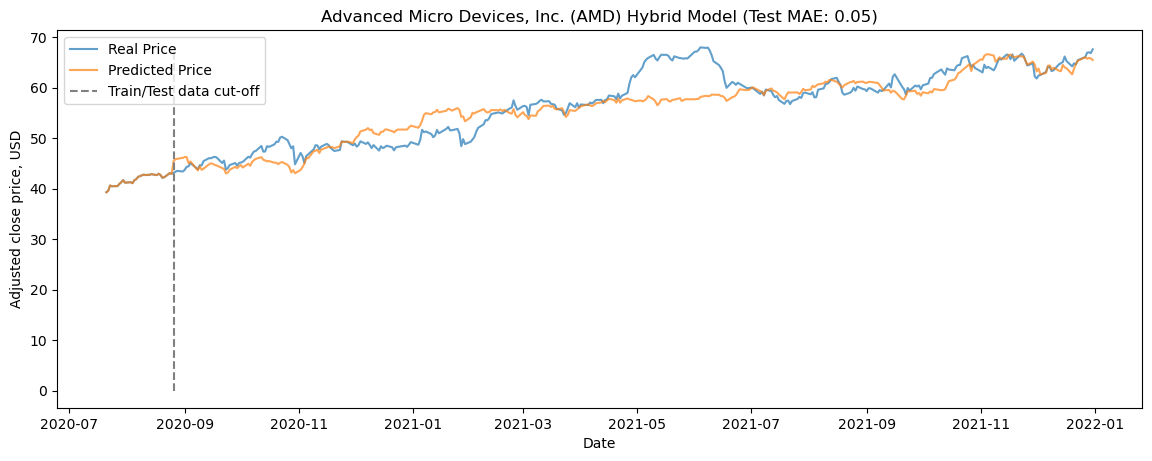

In [309]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'][1900:], df_char['Adj Close'][1900:], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'][1900:], df_char['Predicted Close'][1900:], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title(f'Advanced Micro Devices, Inc. (AMD) Hybrid Model ({file_chart_name})')
plt.legend()
plt.savefig(f"pictures/hybrid_model_gru_test_MAE_{file_chart_name[-4:]}_predicted_period.png")
plt.show()

## LSTM-BiLSTM two branches input model

In [310]:
tf.keras.backend.clear_session()

In [312]:
company_inputs = Input(shape=(1, X_train_company.shape [2]))
x = LSTM(128, activation = "relu", return_sequences=True)(company_inputs)
x = LSTM(64, activation = "relu", return_sequences=True)(x)
x = LSTM(32, activation = "relu",return_sequences=True)(x)
x = LSTM(16, activation = "relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=True)(x)
x = LSTM(32, activation = "relu", return_sequences=True)(x)
x = LSTM(16, activation = "relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),return_sequences=False)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.20)(x)
company_outputs = Dense(42)(x)

stocks_inputs = Input(shape=(1, X_train_stocks.shape [2]))
x = Bidirectional(LSTM(128, activation = "relu", return_sequences=True))(stocks_inputs)
x = Bidirectional(LSTM(64, activation = "relu", return_sequences=False))(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
stocks_outputs = Dense(86)(x)

concatenated = Concatenate()([company_outputs, stocks_outputs])
x = Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(concatenated)
x = Dropout(0.10)(x)
x = Dense(64, activation='relu', kernel_regularizer="l2")(x)
out = Dense(1, activation='linear')(x)

hybrid_model = Model(inputs=[company_inputs, stocks_inputs], outputs=out)

In [313]:
hybrid_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1, 42)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1, 86)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 1, 128)       87552       input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 1, 256)       220160      input_4[0][0]                    
_______________________________________________________________________________________

In [57]:
opt_adadelta = Adadelta(lr=0.1, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.001, beta_1=0.90, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.90, epsilon=1e-08, decay=0.0)
epochs = 150
batch_size = 128
validation_split = 0.0

In [58]:
hybrid_model, history_hybrid = compile_fit_model([X_train_company, X_train_stocks], y_train_company, \
                "company_predictor_hybrid_lstm_gru.keras", hybrid_model, opt_rms, epochs, batch_size, validation_split)

Epoch 1/150
16/16 [==============================] - 0s 13ms/step - loss: 1.1210 - mae: 0.1235
Epoch 2/150
16/16 [==============================] - 0s 13ms/step - loss: 0.8069 - mae: 0.0800
Epoch 3/150
16/16 [==============================] - 0s 13ms/step - loss: 0.5842 - mae: 0.0661
Epoch 4/150
16/16 [==============================] - 0s 14ms/step - loss: 0.4093 - mae: 0.0555
Epoch 5/150
16/16 [==============================] - 0s 13ms/step - loss: 0.2764 - mae: 0.0523
Epoch 6/150
16/16 [==============================] - 0s 14ms/step - loss: 0.1781 - mae: 0.0471
Epoch 7/150
16/16 [==============================] - 0s 14ms/step - loss: 0.1103 - mae: 0.0439
Epoch 8/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0642 - mae: 0.0401
Epoch 9/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0357 - mae: 0.0411
Epoch 10/150
16/16 [==============================] - 0s 16ms/step - loss: 0.0185 - mae: 0.0378
Epoch 11/150
16/16 [=============================

16/16 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0285
Epoch 34/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0265
Epoch 35/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0249
Epoch 36/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0020 - mae: 0.0284
Epoch 37/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0304
Epoch 38/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0270
Epoch 39/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0018 - mae: 0.0274
Epoch 40/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0016 - mae: 0.0260
Epoch 41/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0265
Epoch 42/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0298
Epoch 43/150
16/16 [==============================] -

16/16 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0250
Epoch 99/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0246
Epoch 100/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0222
Epoch 101/150
16/16 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0253
Epoch 102/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0249
Epoch 103/150
16/16 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0236
Epoch 104/150
16/16 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0253
Epoch 105/150
16/16 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.0215
Epoch 106/150
16/16 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0245
Epoch 107/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0269
Epoch 108/150
16/16 [========================

In [59]:
mae = round(hybrid_model.evaluate([X_test_company, X_test_stocks], y_test_company)[1], 2)
file_chart_name = f"Test MAE: {mae}"
print(f"Test MAE: {mae}")

11/11 [==============================] - 0s 2ms/step - loss: 0.0060 - mae: 0.0623
Test MAE: 0.06


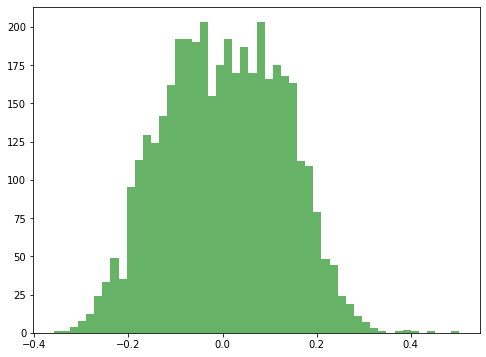

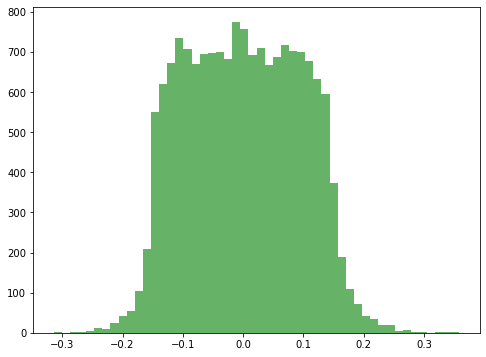

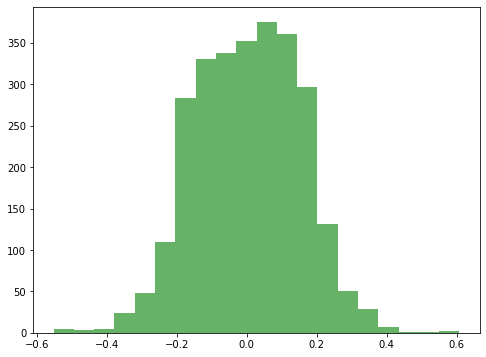

In [60]:
plt.figure()
plt.hist(hybrid_model.layers[13].kernel.numpy().ravel(), bins = 50, facecolor='g', alpha=0.6)
plt.figure()
plt.hist(hybrid_model.layers[7].kernel.numpy().ravel(), bins = 50, facecolor='g', alpha=0.6)
plt.figure()
plt.hist(hybrid_model.layers[19].kernel.numpy().ravel(), bins = 20, facecolor='g', alpha=0.6)
plt.show()


In [61]:
hist = pd.DataFrame(history_hybrid.history)
hist['epoch'] = history_hybrid.epoch
hist.tail()

,loss,mae,epoch
145,0.001237,0.021712,145
146,0.001106,0.020721,146
147,0.001209,0.021836,147
148,0.001293,0.023242,148
149,0.001310,0.023725,149


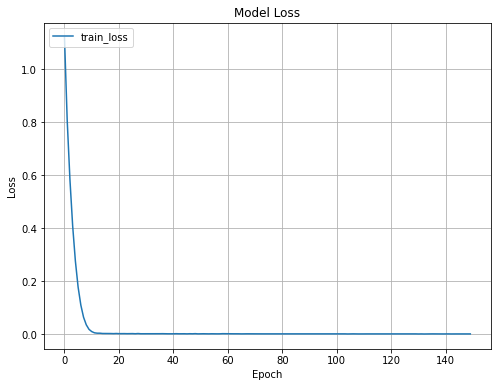

In [62]:
plt.figure()
plt.plot(history_hybrid.history['loss'])
plt.legend(['train_loss'], loc='upper left')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.grid(True)

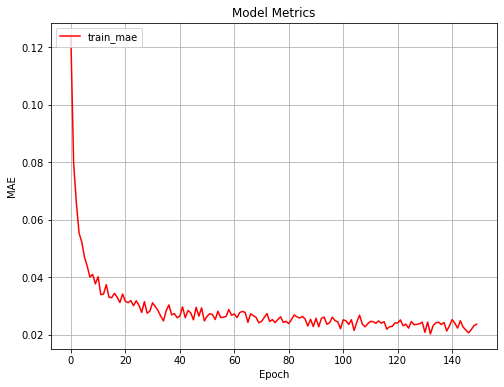

In [63]:
plt.figure()    
plt.plot(history_hybrid.history['mae'], c="red") 
plt.legend(['train_mae'], loc='upper left')
plt.title('Model Metrics')
plt.ylabel('MAE')
plt.xlabel('Epoch') 
      
plt.grid(True)

In [70]:
predicted_stock_price = hybrid_model.predict([X_test_company, X_test_stocks])

In [71]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
before_df = pd.DataFrame(company_df.iloc[0:1926, 0:2])
before_df["Predicted Close"] = before_df["Adj Close"]
df_char = pd.concat([before_df, predicted_df])
df_char["Year"] = pd.DatetimeIndex(df_char['Date']).year
df_char

,Date,Adj Close,Predicted Close,Year
0,2013-01-02,22.333015,22.333015,2013
1,2013-01-03,22.153860,22.153860,2013
2,2013-01-04,22.761452,22.761452,2013
3,2013-01-07,21.818907,21.818907,2013
4,2013-01-08,22.075964,22.075964,2013
...,...,...,...,...
2262,2021-12-27,66.070000,68.689674,2021
2263,2021-12-28,66.930000,68.506973,2021
2264,2021-12-29,67.010002,68.643410,2021
2265,2021-12-30,66.860001,68.537483,2021


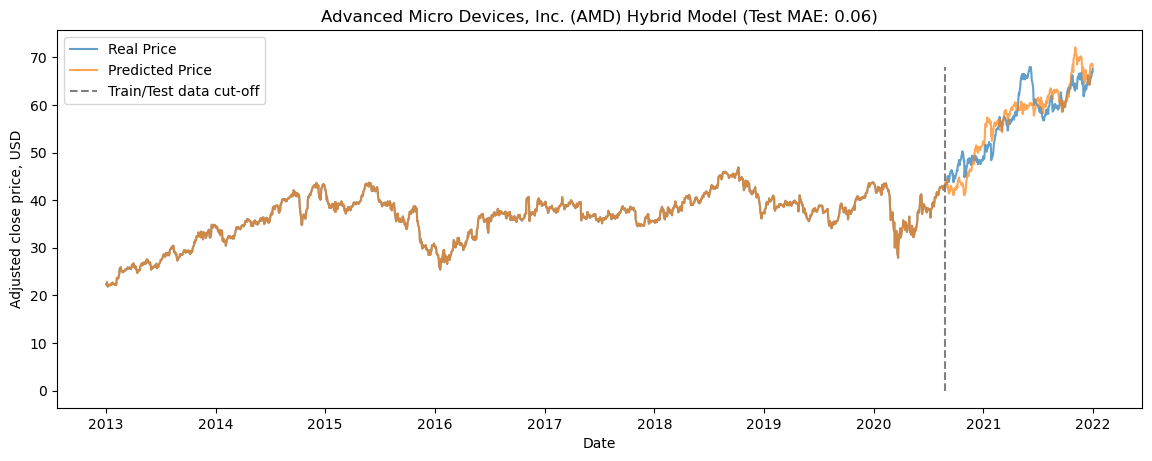

In [72]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title(f'Advanced Micro Devices, Inc. (AMD) Hybrid Model ({file_chart_name})')
plt.legend()
plt.savefig(f"pictures/hybrid_model_bilstm_test_MAE_{file_chart_name[-4:]}.png")
plt.show()

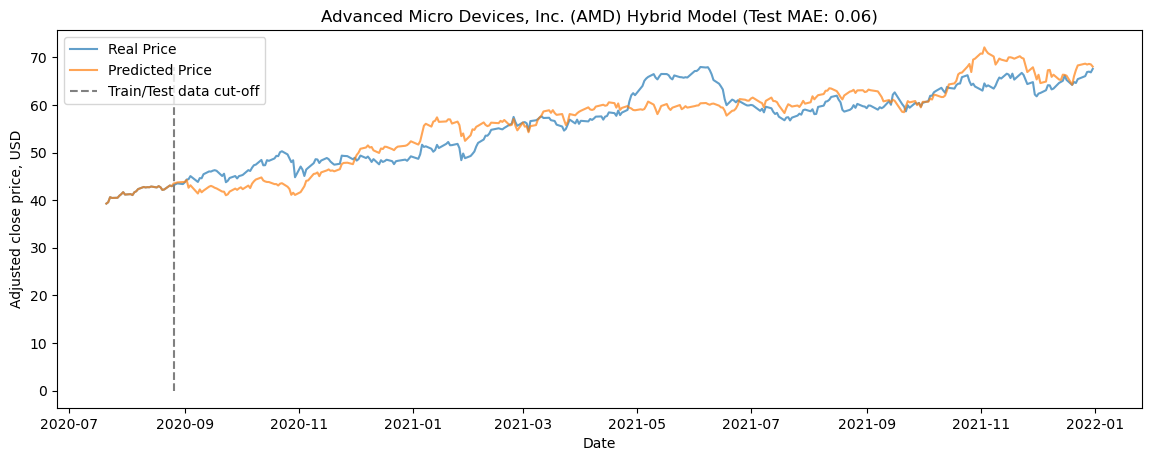

In [67]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'][1900:], df_char['Adj Close'][1900:], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'][1900:], df_char['Predicted Close'][1900:], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title(f'Advanced Micro Devices, Inc. (AMD) Hybrid Model ({file_chart_name})')
plt.legend()
plt.savefig(f"pictures/hybrid_model_bilstm_test_MAE_{file_chart_name[-4:]}_predicted_period.png")
plt.show()

In [ ]:
#https://datascience.stackexchange.com/questions/76826/why-are-predictions-from-my-lstm-neural-network-lagging-behind-true-values